# This notebook is to:

### Read and Summerize the dataset

### Engineering Time Seies Features

### Training the model

### Python Time Series Packages intro

In [43]:
import pandas as pd
import numpy as np
import calendar
import datetime
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import sklearn.grid_search as gs
from sklearn.cross_validation import train_test_split
from sklearn.learning_curve import learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import datasciencetools as dst
import pickle
% matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

# Read and Summerize the dataset

In [44]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
df_origin = pd.read_csv("AirPassengers.csv", parse_dates='Month', index_col='Month',date_parser=dateparse)
print "__"*20
print "Head:"
print df_origin.head()

print "__"*20
print "Summary:"
print df_origin.describe()
print "__"*20


________________________________________
Head:
            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121
________________________________________
Summary:
       #Passengers
count   144.000000
mean    280.298611
std     119.966317
min     104.000000
25%     180.000000
50%     265.500000
75%     360.500000
max     622.000000
________________________________________


In [45]:
#df_origin  = read_data("test_TS.csv")
#df_origin  = df_origin.drop(["Unnamed: 0"], axis=1)

In [46]:
# df_origin  = df_origin.groupby("date").sum()
# df_origin['date'] = df_origin.index

# Engineering Time Seies Features

In [47]:
# parse the date column to 3 columns, year, month and day

In [48]:
df_origin['Month'] = df_origin.index
df = df_origin.copy()
df['month'] = pd.to_datetime(df['Month']).dt.month.astype('category')
df['month'] = df['month'].apply(lambda x: calendar.month_abbr[x])

In [49]:
#df['date'] = pd.to_datetime(df["Month"])
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
df['weekday'] = df['Month'].dt.dayofweek.map(dayOfWeek)
nan_rows = df[df.isnull().T.any().T]

In [50]:
# Create dummies
weekday_dummies = pd.get_dummies(df['weekday'])
month_dummies = pd.get_dummies(df['month'])
del df["weekday"]
del df['month']

In [51]:
# Add the new features to the main dataframe
df = pd.concat([df, weekday_dummies,month_dummies],axis=1)
print df.head()

            #Passengers      Month  Friday  Monday  Saturday  Sunday  \
Month                                                                  
1949-01-01          112 1949-01-01       0       0         1       0   
1949-02-01          118 1949-02-01       0       0         0       0   
1949-03-01          132 1949-03-01       0       0         0       0   
1949-04-01          129 1949-04-01       1       0         0       0   
1949-05-01          121 1949-05-01       0       0         0       1   

            Thursday  Tuesday  Wednesday  Apr ...   Dec  Feb  Jan  Jul  Jun  \
Month                                         ...                             
1949-01-01         0        0          0    0 ...     0    0    1    0    0   
1949-02-01         0        1          0    0 ...     0    1    0    0    0   
1949-03-01         0        1          0    0 ...     0    0    0    0    0   
1949-04-01         0        0          0    1 ...     0    0    0    0    0   
1949-05-01         0 

### Feature: Lagged portions

In [52]:
df["one_day_ago_value"] = df["#Passengers"].shift(1)
df["Two_days_ago_value"] = df["#Passengers"].shift(2)
df["Three_days_ago_value"] = df["#Passengers"].shift(3)

# make sure to drop NAN values
df = df[np.isfinite(df["Three_days_ago_value"])]

Visualize  

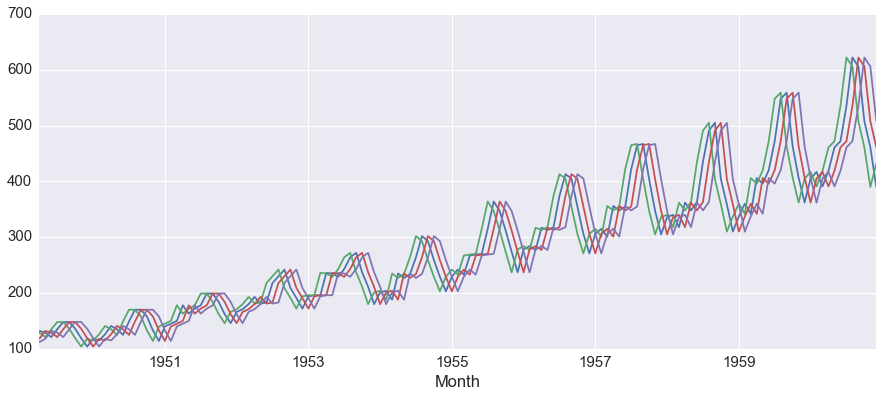

In [53]:
df['one_day_ago_value'].plot()
df["#Passengers"].plot()
df['Two_days_ago_value'].plot()
df['Three_days_ago_value'].plot()

benfits?

### Auto-Regressive (AR) terms

In [54]:
df_binned = df
df['Value_Diff'] = df_binned["#Passengers"].diff().shift()
df['Linear_Approx'] = ((df_binned["#Passengers"].shift(1)) + df_binned["#Passengers"].diff().shift(1))

### Rolling mean expanding window feature



In [55]:
df['Rolling Mean Expanding Window'] = pd.rolling_mean(df_binned["#Passengers"].shift(1), window=len(df_binned.shift(1)), min_periods=1)
# check out the new version of pandas!

visualize: 

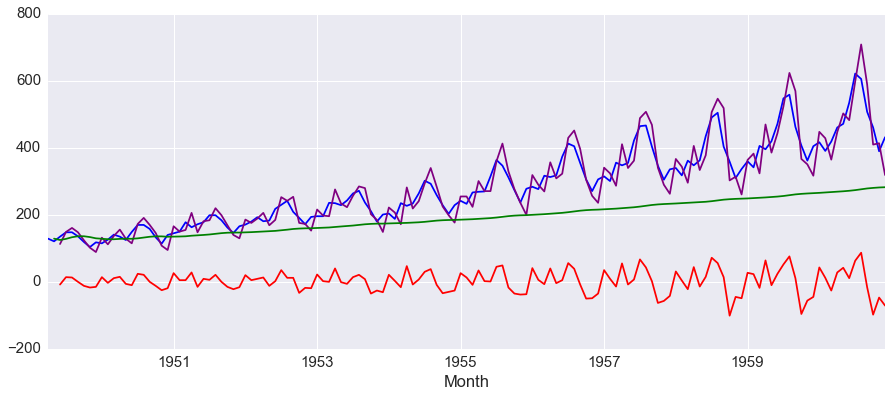

In [56]:
df["#Passengers"].plot(color = 'blue')
df['Value_Diff'].plot(color = 'red')
df['Linear_Approx'].plot(color = 'purple')
df['Rolling Mean Expanding Window'].plot(color ='green')

benfits?

### Moving Average (MA) terms

In [57]:
df['Moving Average(1)'] = df_binned["#Passengers"].shift(1) - pd.rolling_mean(df_binned["#Passengers"].shift(1), window=len(df_binned.shift(1)), min_periods=1)
df['Moving Average(2)'] = df_binned["#Passengers"].shift(2) - pd.rolling_mean(df_binned["#Passengers"].shift(2), window=len(df_binned.shift(2)), min_periods=1)
df['Moving Average(3)'] = df_binned["#Passengers"].shift(3) - pd.rolling_mean(df_binned["#Passengers"].shift(3), window=len(df_binned.shift(3)), min_periods=1)
df = df[np.isfinite(df['Moving Average(3)'])]
df = df.fillna(df.mean(), inplace=True)

visualize:

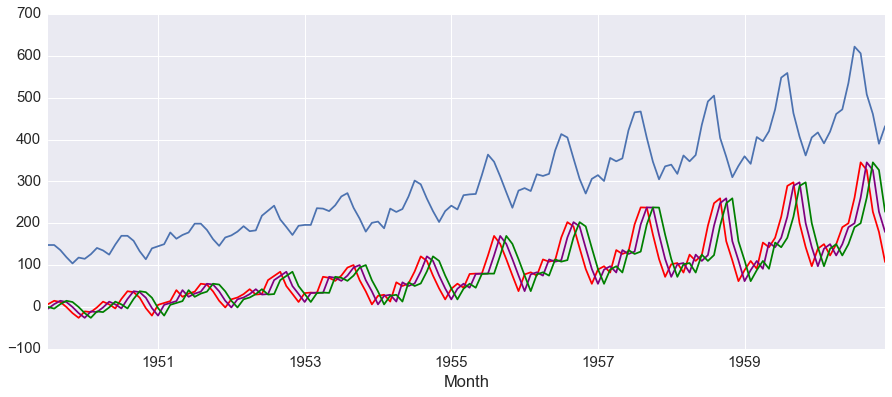

In [58]:
df["#Passengers"].plot()
df['Moving Average(1)'].plot(color ='red')
df['Moving Average(2)'].plot(color = 'purple')
df['Moving Average(3)'].plot(color = 'green')

benfits?

how many columns we have? and how is the dataframe looks right now?

In [59]:
print list(df.columns)
print len(df.columns)
print df.head()

['#Passengers', 'Month', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep', 'one_day_ago_value', 'Two_days_ago_value', 'Three_days_ago_value', 'Value_Diff', 'Linear_Approx', 'Rolling Mean Expanding Window', 'Moving Average(1)', 'Moving Average(2)', 'Moving Average(3)']
30
            #Passengers      Month  Friday  Monday  Saturday  Sunday  \
Month                                                                  
1949-07-01          148 1949-07-01       1       0         0       0   
1949-08-01          148 1949-08-01       0       1         0       0   
1949-09-01          136 1949-09-01       0       0         0       0   
1949-10-01          119 1949-10-01       0       0         1       0   
1949-11-01          104 1949-11-01       0       0         0       0   

            Thursday  Tuesday  Wednesday  Apr        ...          Sep  \
Month                                 

# Training the model

In [60]:
Y_value = df["#Passengers"]
X_featu  = df.drop(["#Passengers",'Month' ],axis=1)  

 we will split the data to training and test dataset 

In [61]:
X_train, X_test, Y_train, Y_test =  train_test_split(X_featu,Y_value, test_size=0.2, random_state=0)

will call Random Forest regressor 

In [62]:
randomForest = RandomForestRegressor(random_state=1)

GridSearch to find best model

In [63]:

grid_para_forest = {'n_estimators': [5,10,100,500],'max_depth':[5,10,20,25,30,35],'min_samples_leaf':[2,3,4,5,10,20]}
grid_search_forest = gs.GridSearchCV(randomForest, grid_para_forest, n_jobs = -1)
grid_search_forest.fit(X_train, Y_train)

In [64]:
print "grid best params:", grid_search_forest.best_params_
print "_"*30
print "grid search forest:", grid_search_forest.best_estimator_
print "_"*30
print "Best score is %0.5f:"% grid_search_forest.best_score_

grid best params: {'n_estimators': 500, 'max_depth': 10, 'min_samples_leaf': 2}
______________________________
grid search forest: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)
______________________________
Best score is 0.92403:


In [65]:
forest  = grid_search_forest.best_estimator_
forest.fit(X_train, Y_train)

check the residuals and outliers using the hold-out method

Residual sum of squares: 
184.608984194
MSE train: 201.030, test: 1525.254
R^2 train: 0.986, test: 0.843


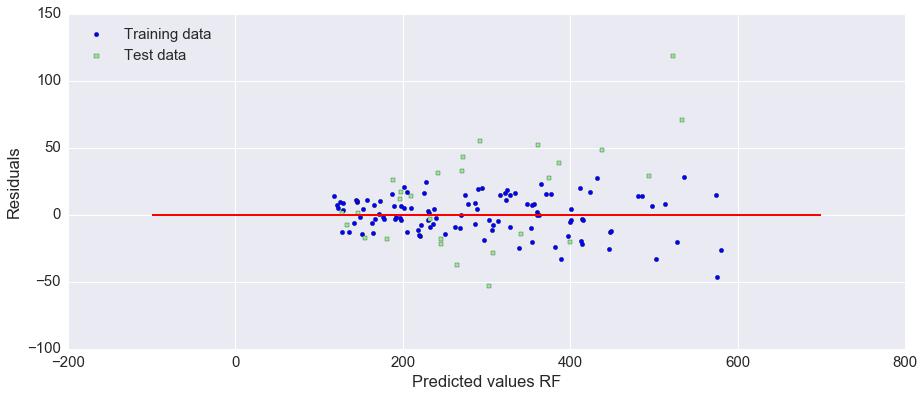

In [ ]:
Y_test_rf = np.array(Y_test).astype(float)
Y_train_rf = np.array(Y_train).astype(float)
y_train_pred_rf = forest.predict(X_train)
y_test_pred_rf =  forest.predict(X_test)
print "Residual sum of squares: \n" ,np.mean(y_test_pred_rf - Y_test_rf) ** 2


print('MSE train: %.3f, test: %.3f' % (mean_squared_error(Y_train_rf, y_train_pred_rf),
                                       mean_squared_error(Y_test_rf, y_test_pred_rf)))
print('R^2 train: %.3f, test: %.3f' % (r2_score(Y_train_rf, y_train_pred_rf),
                                       r2_score(Y_test_rf, y_test_pred_rf)))
plt.scatter(y_train_pred_rf, y_train_pred_rf - Y_train_rf, c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred_rf, y_test_pred_rf - Y_test_rf, c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values RF')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-100, xmax=700, lw=2, color='red')
#plt.ylim([-.9, .9])
plt.show()

Need to verify the model is not overfitting;
by plotting the learning curve for random forest (using 10 folds)

In [ ]:
train_sizes_forest, train_scores_forest, test_scores_forest = learning_curve(estimator=forest,
                                            X=X_train,
                                            y=Y_train,
                                            train_sizes=np.linspace(0.1, 1.0, 10),
                                            cv=10)

In [ ]:
train_mean_forest = np.mean(train_scores_forest, axis=1)
train_std_forest = np.std(train_scores_forest, axis=1)
test_mean_forest = np.mean(test_scores_forest, axis=1)
test_std_forest = np.std(test_scores_forest, axis=1)

In [ ]:
# plot
plt.plot(train_sizes_forest, train_mean_forest,color='blue', marker='o',markersize=5,label='training accuracy')
plt.fill_between(train_sizes_forest, train_mean_forest + train_std_forest, train_mean_forest - train_std_forest,alpha=0.15, color='blue')
plt.plot(train_sizes_forest, test_mean_forest, color='purple', linestyle='--', marker='s', markersize=5, label='validation accuracy for Random Forest')
plt.fill_between(train_sizes_forest, test_mean_forest + test_std_forest, test_mean_forest - test_std_forest, alpha=0.15, color='red')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Tune the algorithm even more?

plot the original data vs predicted: 


In [ ]:
df['forest'] = forest.predict(X_featu)

In [ ]:
df["#Passengers"].plot()
df['forest'].plot()

### Feature importance

In [ ]:
importances = forest.feature_importances_

In [ ]:
indices = np.argsort(importances)[::-1]
feat_labels = X_featu.columns[list(indices)]
print feat_labels
print len(feat_labels)
print list(indices)

In [ ]:
# dst.plot_feature_importances(feat_labels, importances, Nfeatures=10)
# plt.savefig("feature_importance_randomForest.png")
# plt.show()

# Python: Time Series Packages 

### tsfresh package can be used to select time series features 

In [ ]:
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, \
load_robot_execution_failures
download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()

In [ ]:
from tsfresh import extract_features
df, _ = load_robot_execution_failures()
X = extract_features(df, column_id='id', column_sort='time')

In [ ]:
list(X.columns)

# PyFlux package
### An open source time series library for the Python Programming Language. provide mixtures of time series models and features 

# Questions:

In [ ]:
# Any time series features you suggest us to try? would you like to show us how?